In [27]:
import src.gen_synthetic as gen_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import detrend
from scipy import stats
import src.onlineSLE as utility
import periodicity_detection as period
import os
import math

## Section IV.D Error in Numerical Computation in SDFT

In [28]:
ts1 = gen_data.generate_syn1(residual_rate=0.05, is_export=False)
win1 = math.ceil(int(max(ts1['ground_truth'])) * 5) 
ts2 = gen_data.generate_syn2(residual_rate=0.05, is_export=False)
win2 = math.ceil(int(max(ts2['ground_truth'])) * 5) 

def s_sdf_SLE(input_ts,sliding_window_size):
    results = []
    W = input_ts[:sliding_window_size]
    mathcal_F = fft(W)
    
    N = len(mathcal_F)
    k = np.arange(N)
    twiddle = np.exp(2j * np.pi * k / N)
    
    results.append(mathcal_F)
    for idx, x_t in enumerate(input_ts[sliding_window_size:]):
        x_oldest = W[0]
        W = W[1:]
        W = np.append(W, x_t)
        mathcal_F = utility.update_sDFT(mathcal_F, x_oldest, x_t, twiddle)
        results.append(mathcal_F)
    return results

def s_scipy_fft(input_ts,sliding_window_size):
    results = []
    for idx in range(len(input_ts) - sliding_window_size + 1):
        buffer = input_ts[idx:sliding_window_size + idx]
        results.append(fft(buffer))
    return results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


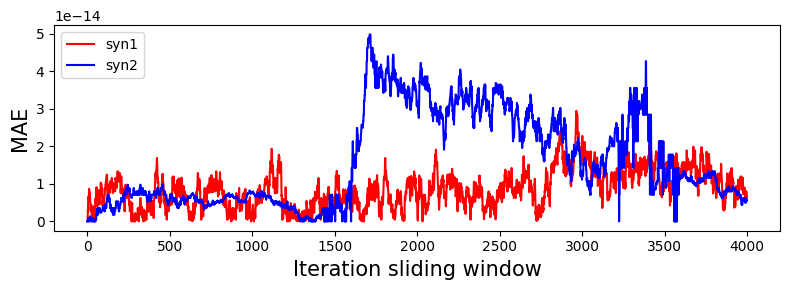

In [29]:
error_results = []
for ts,name,window_size in zip([ts1['ts'],ts2['ts']], ['Syn1', 'Syn2'], [win1,win2]):
    ts = stats.zscore(ts)
    sdft_results = s_sdf_SLE(ts, window_size)
    fft_results = s_scipy_fft(ts, window_size)
    error_result = []
    for sdft_result, fft_result in zip(sdft_results, fft_results):
        error_result.append(abs(sdft_result[0] - fft_result[0]))
    error_results.append(error_result)
    
plt.figure(figsize=(8, 3))

plt.plot(error_results[0][:4000], color='red', label='syn1')
plt.plot(error_results[1][:4000], color='blue', label='syn2')
plt.xlabel('Iteration sliding window', fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('Fig5.eps' ,format='eps')
plt.show()

## Section IV.D Influence of the sliding window size

In [30]:
noise_level = 0.05
syn2 = gen_data.generate_syn2(residual_rate=noise_level, is_export=False)
ts = syn2['ts']
answer = syn2['ground_truth']
sliding_window_sizes = [300, 400, 500]

## AutoPeriod

In [31]:
for sliding_window_size in sliding_window_sizes:
    autoperiod_result = []
    ts = np.array(ts)
    for idx in range(len(ts) - sliding_window_size + 1):
        W = ts[idx:sliding_window_size + idx]
        SLE_result = period.autoperiod(W)
        autoperiod_result.append({'idx_win': sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx - 1],
                                    'result': SLE_result})
    
    print(utility.result_aggregation(f'syn2_w{sliding_window_size}', 'autoperiod',autoperiod_result))

[{'dataset_name': 'syn2_w300', 'algorithms': 'autoperiod', 'error_bound': 0, 'accuracy_ratio': 0.526}, {'dataset_name': 'syn2_w300', 'algorithms': 'autoperiod', 'error_bound': 20, 'accuracy_ratio': 0.929}]
[{'dataset_name': 'syn2_w400', 'algorithms': 'autoperiod', 'error_bound': 0, 'accuracy_ratio': 0.696}, {'dataset_name': 'syn2_w400', 'algorithms': 'autoperiod', 'error_bound': 20, 'accuracy_ratio': 0.91}]
[{'dataset_name': 'syn2_w500', 'algorithms': 'autoperiod', 'error_bound': 0, 'accuracy_ratio': 0.809}, {'dataset_name': 'syn2_w500', 'algorithms': 'autoperiod', 'error_bound': 20, 'accuracy_ratio': 0.853}]


## Find length

In [32]:
for sliding_window_size in sliding_window_sizes:
    find_length_result = []
    ts = np.array(ts)
    for idx in range(len(ts) - sliding_window_size + 1):
        W = ts[idx:sliding_window_size + idx]
        SLE_result = period.find_length(W)
        find_length_result.append({'idx_win': sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx - 1],
                                    'result': SLE_result})
    
    print(utility.result_aggregation(f'syn2_w{sliding_window_size}', 'find_length',find_length_result))

[{'dataset_name': 'syn2_w300', 'algorithms': 'find_length', 'error_bound': 0, 'accuracy_ratio': 0.518}, {'dataset_name': 'syn2_w300', 'algorithms': 'find_length', 'error_bound': 20, 'accuracy_ratio': 0.912}]
[{'dataset_name': 'syn2_w400', 'algorithms': 'find_length', 'error_bound': 0, 'accuracy_ratio': 0.683}, {'dataset_name': 'syn2_w400', 'algorithms': 'find_length', 'error_bound': 20, 'accuracy_ratio': 0.875}]
[{'dataset_name': 'syn2_w500', 'algorithms': 'find_length', 'error_bound': 0, 'accuracy_ratio': 0.791}, {'dataset_name': 'syn2_w500', 'algorithms': 'find_length', 'error_bound': 20, 'accuracy_ratio': 0.825}]


## SAZED

In [33]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
sazedR = importr('sazedR')          # sazedR in CRAN

for sliding_window_size in sliding_window_sizes:
    sazedR_result = []
    dataset = np.array(ts)
    for idx in range(len(dataset) - sliding_window_size + 1):
        W = dataset[idx:sliding_window_size + idx]
        W = robjects.FloatVector(W)
        SLE_result = sazedR.sazed(W)
        SLE_result = SLE_result[0]
        sazedR_result.append({'idx_win': sliding_window_size + idx,
                                  'answer': answer[sliding_window_size + idx - 1],
                                  'result': SLE_result})

    print(utility.result_aggregation(f'syn2_w{sliding_window_size}', 'SAZED',sazedR_result))

[{'dataset_name': 'syn2_w300', 'algorithms': 'SAZED', 'error_bound': 0, 'accuracy_ratio': 0.558}, {'dataset_name': 'syn2_w300', 'algorithms': 'SAZED', 'error_bound': 20, 'accuracy_ratio': 0.907}]
[{'dataset_name': 'syn2_w400', 'algorithms': 'SAZED', 'error_bound': 0, 'accuracy_ratio': 0.826}, {'dataset_name': 'syn2_w400', 'algorithms': 'SAZED', 'error_bound': 20, 'accuracy_ratio': 0.908}]
[{'dataset_name': 'syn2_w500', 'algorithms': 'SAZED', 'error_bound': 0, 'accuracy_ratio': 0.796}, {'dataset_name': 'syn2_w500', 'algorithms': 'SAZED', 'error_bound': 20, 'accuracy_ratio': 0.886}]


## onlineSLE

In [34]:
for sliding_window_size in sliding_window_sizes:
    ## offline mode
    onlineSLE_result = []
    W = ts[:sliding_window_size]
    mathcal_F = fft(W)
    N = len(mathcal_F)
    k = np.arange(N)
    twiddle = np.exp(2j * np.pi * k / N)   # twiddle for SDFT

    xfreq, periodogram_den = utility.peridogram(sliding_window_size, mathcal_F)
    peak_index = utility.get_period_hints(periodogram_den)
    if peak_index > 1:
        frequency = xfreq[peak_index]
        SLE_result = round(1 / frequency)
    else:
        SLE_result = 1
    onlineSLE_result.append({'idx_win': sliding_window_size,
                    'answer': answer[sliding_window_size - 1],
                    'result': SLE_result})
    
    ## online mode
    for idx, x_t in enumerate(ts[sliding_window_size:]):
        x_oldest = W[0]
        W = W[1:]
        W = np.append(W, x_t)
        mathcal_F = utility.update_sDFT(mathcal_F, x_oldest, x_t,twiddle)
        xfreq, periodogram_den = utility.peridogram(sliding_window_size, mathcal_F)
        peak_index = utility.get_period_hints(periodogram_den)
        if peak_index > 1:
            frequency = xfreq[peak_index]
            SLE_result = round(1 / frequency)
        else:
            SLE_result = 1
        
        onlineSLE_result.append({'idx_win': 1 + sliding_window_size + idx,
                                    'answer': answer[sliding_window_size + idx],
                                    'result': SLE_result})
        
    print(utility.result_aggregation(f'syn2_w{sliding_window_size}', 'onlineSLE', onlineSLE_result))

[{'dataset_name': 'syn2_w300', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 0.583}, {'dataset_name': 'syn2_w300', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 0.929}]
[{'dataset_name': 'syn2_w400', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 0.91}, {'dataset_name': 'syn2_w400', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 0.91}]
[{'dataset_name': 'syn2_w500', 'algorithms': 'onlineSLE', 'error_bound': 0, 'accuracy_ratio': 0.546}, {'dataset_name': 'syn2_w500', 'algorithms': 'onlineSLE', 'error_bound': 20, 'accuracy_ratio': 0.892}]
